# Implementation of MAXSER

## Step 0: Subpool selection
   1. Form 1000 random subpools of $N^-$ assets
   2. Calculate the adjusted Sharpe ratio, $\hat{\theta}_{adj}$: $$\hat{\theta}_{adj} = \frac{(T-N-2)\hat{\theta}_s-N}{T}+\frac{2(\hat{\theta}_s)^{N/2}(1+\hat{\theta}_s)^{-(T-2)/2}}{TB_{\hat{\theta}_s/(1+\hat{\theta}_s)}(N/2,(T-N)/2)}$$
      where $\hat{\theta}_s$ is the sample estimate of the Sharpe ratio $$\hat{\theta}_s:=\mathbf{\hat{\mu}}'\mathbf{\hat{\Sigma}}^{-1}\mathbf{\hat{\mu}}$$
      and $$B_x(a,b) = \int_0^x y^{a-1}(1-y)^{b-1}dy$$
   3. Select the subpool with $\hat{\theta}_{adj}$ corresponding to 95th percentile.

## Step 1 
   1. Estimate the square of the maximum Sharpe ratio by $\hat{\theta}_{adj}$
   2. Compute response $$\hat{r}_c := \sigma\frac{1+\hat{\theta}}{\sqrt{\hat{\theta}}}$$
   where $\sigma$ is a given risk constraint (i.e. target risk level), and $$\hat{\theta}:=\frac{(T-N-2)\hat{\theta}_s-N}{T}$$

## Step 2
   1. Split the sample into 10 random groups and select $\lambda$ through 10-fold cross-validation:
      - For each training set $i$, obtain the whole solution path $(\mathbf{\omega}_{0≤\zeta≤1})$ using the LASSO type regression
      - Calculate the difference between the risk computed using the validation set and the given risk constraint 
      - $\hat{\zeta}$ is taken to be the average of $\zeta(i), i = 1,\dots,10$
      - Denote selected value by $\hat{\lambda}$
   
## Step 3
   1. Use the estimated $\hat{\lambda}$ in $$\hat{\mathbf{\omega^*}} = \underset{\mathbf{\omega}}{\mathrm{argmin}}\frac{1}{T}\sum_{t=1}^T(\hat{r}_c-\mathbf{\omega}'\mathbf{R_t})^2\quad \text{subect to} \quad ||\mathbf{\omega}||_1≤\hat{\lambda}$$ and solve for the MAXSER portfolio weights $\hat{\mathbf{\omega^*}}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import betainc, beta
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, LassoLars, LinearRegression
from scipy.optimize import minimize

file_path = str(Path().absolute()) + "/data/48_Industry_Portfolios.csv"
data = pd.read_csv(file_path, skiprows=11, nrows=1181, index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m')
data = data.iloc[-120:]      # use last 120 observations (10 years)

file_path = str(Path().absolute()) + "/data/F-F_Research_Data_Factors.csv"
rf_data = pd.read_csv(file_path, skiprows=3, nrows=1181, index_col=0)
rf_data.index = pd.to_datetime(rf_data.index, format='%Y%m')
rf_data.tail()

,Mkt-RF,SMB,HML,RF
2024-07-01,1.24,6.80,5.74,0.45
2024-08-01,1.61,-3.55,-1.13,0.48
2024-09-01,1.74,-0.17,-2.59,0.40
2024-10-01,-0.97,-1.01,0.89,0.39
2024-11-01,6.50,4.63,-0.05,0.40


In [2]:
rf = 0.40                       # most recent risk free rate from factor dataset
data_excess = data - rf         # compute excess returns # convert to percentage
T, N = data.shape
data_excess.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2014-12-01,-0.45,-1.77,-5.57,-4.76,-3.29,-3.08,-5.62,1.46,-0.32,-1.09,...,4.13,1.06,0.11,1.83,-0.89,1.57,1.47,-0.81,3.01,-1.00
2015-01-01,-1.29,-2.49,-1.52,0.48,2.67,-0.53,-0.14,-2.36,-5.01,-4.32,...,-5.06,-4.85,-2.77,-0.82,0.40,-9.82,-4.82,-0.04,-7.86,-4.86
2015-02-01,1.67,3.29,6.09,4.10,5.06,5.02,5.34,7.64,3.17,5.55,...,10.79,2.45,4.64,5.39,6.41,7.58,7.43,5.42,8.11,5.08
2015-03-01,-5.71,2.15,-5.05,-2.48,-8.87,-4.57,-2.50,0.02,-2.73,0.78,...,-3.65,-3.45,0.19,0.53,-0.65,-1.14,1.89,1.00,-0.28,-2.61
2015-04-01,0.63,-0.51,-0.83,-0.89,5.61,8.83,2.76,-4.40,-2.76,-2.05,...,-2.14,-2.01,-1.69,-3.14,0.15,1.66,-2.23,-3.68,0.13,1.24


In [3]:
# Derive a sigma value
cov_matrix = data_excess.cov()
weights = np.full(N, 1 / N)  # naive weights for all assets

var = np.dot(weights.T, np.dot(cov_matrix, weights))
sigma = np.sqrt(var).round(2)
print(sigma)


4.91


In [4]:
# functions
def B_x(x, a, b):
    """
    computes non-normalized incomplete beta function
    ---
    :param x: value up to which we integrate to in incomplete beta function
    :param a: alpha value in Beta function
    :param b: beta value in Beta function
    :return: the non-normalized beta function in the adjusted squared sharpe ratio
    """
    return betainc(a, b, x) * beta(a, b)


def sample_sharpe_s(returns):
    """
    Computes the sample unadjusted squared Sharpe Ratio
    ---
    :param returns: DataFrame of returns
    :return: squared estimated (non-adjusted) Sharpe Ratio
    """
    mu = np.mean(returns, axis=0)
    Sigma = np.cov(returns, rowvar=False)
    inv_Sigma = np.linalg.inv(Sigma)
    return mu.T @ inv_Sigma @ mu  # squared max Sharpe ratio estimate


def adj_sharpe_hat(theta_s, T, N):
    """
    Computes the Adjusted squared Sharpe Ratio
    ---
    :param theta_s: squared estimated (non-adjusted) Sharpe Ratio
    :param T: number of observations (rows) in DataFrame of returns
    :param N: number of assets considered (columns) in DataFrame of returns
    :return: adjusted estimate of squared Sharpe Ratio
    """
    first_term = ((T - N - 2) * theta_s - N) / T
    second_num = 2 * (theta_s ** (N / 2)) * ((1 + theta_s) ** (-(T - 2) / 2))
    B_val = B_x(theta_s / (1 + theta_s), N / 2, (T - N) / 2)
    second_term = second_num / (T * B_val)
    theta_adj = first_term + second_term
    return theta_adj


def maxser_weights(data, response, lambda_val):
    """
    Estimates weights of MAXSER portfolio by minimizing Lasso type sum of squares objective function
    ---
    :param data: DataFrame of returns
    :param response: target return in the Lasso Type objective function
    :param lambda: hyperparameter to regularize weights in Lasso Type objective function
    :return: weights which minimize the lasso-type objective function
    """

    X = data
    y = np.full(X.shape[0], response)

    def loss_fn(weights):
        return np.mean((y - X @ weights) ** 2)
    
    # Lasso Type L1 constraint
    constraints = ({'type': 'ineq', 'fun': lambda w: lambda_val - np.sum(np.abs(w))})
    bounds = [(None, None)] * data.shape[1]

    result = minimize(loss_fn, 
                      np.ones(data.shape[1]) / data.shape[1], 
                      bounds=bounds, 
                      constraints=constraints, 
                      method="SLSQP")
    return result.x

In [5]:
# Step 0: Subpool selection
n_subpools = 1000
subpool_size = 24
subpool_adj_sharpes = []
subpool_indices = []

np.random.seed(60202)


for _ in range(n_subpools):
    selected_cols = np.random.choice(data_excess.columns, subpool_size, replace=False)
    sub_data = data_excess[selected_cols].values
    theta_s = sample_sharpe_s(sub_data)
    theta_adj = adj_sharpe_hat(theta_s, T, subpool_size)
    subpool_adj_sharpes.append(theta_adj)
    subpool_indices.append(selected_cols)

threshold = np.percentile(subpool_adj_sharpes, 95)
candidate_indices = np.where(np.array(subpool_adj_sharpes) >= threshold)[0]
best_idx = candidate_indices[0]  # first that meets or exceeds 95th percentile
best_subpool = subpool_indices[best_idx]
print("Selected industries:", best_subpool)
# assign sharpe corresponding to best subpool
best_sharpe = subpool_adj_sharpes[best_idx]
print("Best adjusted Sharpe ratio:", best_sharpe)

Selected industries: ['Fin  ' 'RlEst' 'Other' 'Toys ' 'Whlsl' 'Guns ' 'Txtls' 'Steel' 'Smoke'
 'Gold ' 'Trans' 'Mach ' 'Chems' 'Chips' 'Meals' 'Util ' 'Insur' 'FabPr'
 'LabEq' 'Banks' 'Aero ' 'BldMt' 'PerSv' 'Paper']
Best adjusted Sharpe ratio: 0.21086803115695038


In [6]:
# Step 1: Compute r_c
r_c = sigma * (1 + best_sharpe) / np.sqrt(best_sharpe)
print(r_c)

12.947112862484103


In [7]:
# Step 2: 10-fold CV to select lambda

# take norm and multiply by vector e.g. [0.1, 0.2, ..., 0.9] for solution path for lambda
# apply CV to find best lambda
# use naive sharpe_adj or global MV for rough benchmark

X = data_excess[best_subpool].values
y = np.full(shape=(X.shape[0]) , fill_value=r_c)

# Compute OLS solution
ols = LinearRegression(fit_intercept=False)
ols.fit(X, y)
w_ols = ols.coef_
# L1 norm of OLS solution
norm_w_ols = np.linalg.norm(w_ols, ord=1)

# Define a range of zeta values: from 0.01 to 0.99 in increments of 0.01
zetas_grid = np.linspace(0.01, 0.99, 99)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

best_zetas = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_zeta_fold = None
    best_diff_fold = np.inf

    # Try each zeta in the grid
    for z in zetas_grid:
        current_lambda = z * norm_w_ols
        
        """
        lars_cv = LassoLars(alpha=current_lambda, fit_intercept=False)
        lars_cv.fit(X_train, y_train)
        w_cv = lars_cv.coef_
        """
        
        w_cv = maxser_weights(X_train, r_c, current_lambda)
        
        # Evaluate portfolio risk on test fold
        sigma_p = np.std(X_test @ w_cv)
        diff = abs(sigma_p - sigma)

        if diff < best_diff_fold:
            best_diff_fold = diff
            best_zeta_fold = z

    best_zetas.append(best_zeta_fold)

zeta_hat = np.mean(best_zetas)
lambda_hat = zeta_hat * norm_w_ols

print("OLS weights:", w_ols)
print("L1 norm of OLS weights:", norm_w_ols)
print("Selected zeta values per fold:", best_zetas)
print("Mean zeta across folds:", zeta_hat)
print("Resulting lambda_hat:", lambda_hat)

OLS weights: [ 0.66530261 -0.44380938 -0.48010507 -0.35992627 -0.75143704  0.07023115
 -0.12455139 -0.07164967  0.4480774   0.20508627 -0.28995679  0.72884977
 -0.7029208   0.48476024  0.66079061  0.00815276  1.37890976 -0.01656811
  0.37510884 -0.17809588  0.22070437  1.10062266 -0.68032286 -1.5396623 ]
L1 norm of OLS weights: 11.9856020014482
Selected zeta values per fold: [0.39, 0.2, 0.5, 0.34, 0.62, 0.47000000000000003, 0.65, 0.18000000000000002, 0.9400000000000001, 0.45]
Mean zeta across folds: 0.4740000000000001
Resulting lambda_hat: 5.681175348686447


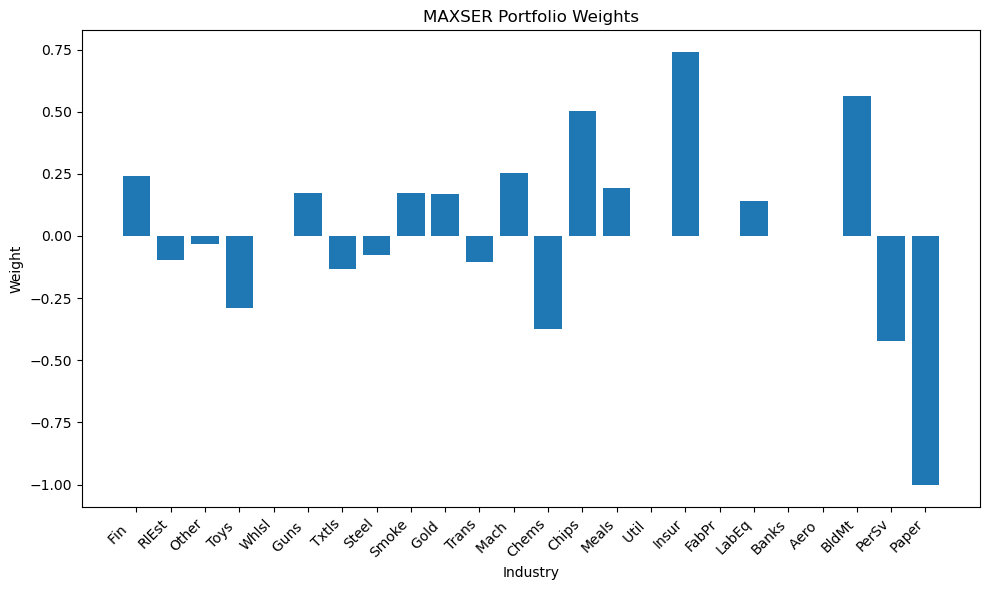

             Weight
Fin    2.415071e-01
RlEst -9.719263e-02
Other -3.101454e-02
Toys  -2.904272e-01
Whlsl -2.569123e-07
Guns   1.722366e-01
Txtls -1.316820e-01
Steel -7.801371e-02
Smoke  1.721732e-01
Gold   1.690158e-01
Trans -1.055869e-01
Mach   2.543113e-01
Chems -3.731645e-01
Chips  5.007672e-01
Meals  1.926270e-01
Util  -4.591323e-08
Insur  7.400891e-01
FabPr -6.205739e-09
LabEq  1.415569e-01
Banks  1.353093e-09
Aero  -1.054274e-08
BldMt  5.630473e-01
PerSv -4.228787e-01
Paper -1.003883e+00
Total  6.134877e-01


In [8]:
# Step 3: Solve for final weights with selected lambda
"""
final_lasso = Lasso(alpha=lambda_hat, fit_intercept=False)
final_lasso.fit(X, y)
w_star = final_lasso.coef_
"""

w_star = maxser_weights(X, r_c, lambda_hat)

# Plot the weights
plt.figure(figsize=(10, 6))
plt.bar(best_subpool, w_star)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Industry')
plt.ylabel('Weight')
plt.title('MAXSER Portfolio Weights')
plt.tight_layout()
plt.show()

# Print table of portfolio weights
weights_df = pd.DataFrame(w_star, index=best_subpool, columns=['Weight'])
weights_df.loc['Total'] = weights_df['Weight'].sum()

print(weights_df)

In [ ]:
print("L1 Norm of weights from MAXSER Portfolio:", sum(abs(w_star)))
print("Standard Deviation of MAXSER Portfolio In-Sample:", np.sqrt(w_star.T @ data_excess[best_subpool].cov() @ w_star))
print("Target Standard Deviation:", sigma)
sharpe_ratio = (w_star @ data[best_subpool].mean() - rf) / np.sqrt(w_star @ data[best_subpool].cov() @ w_star)
print("Sharpe Ratio: ", sharpe_ratio)

L1 Norm of weights from MAXSER Portfolio: 5.681175492891523
Standard Deviation of MAXSER Portfolio In-Sample: 4.464102756482475
Target Standard Deviation: 4.91
MAXSER Portfolio Sharpe: 0.6278115621921454
